### Query from waterbox bucket

In [47]:
# 引入相關套件
import influxdb_client
import os
import time
from datetime import datetime, timedelta, timezone
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# InfluxDB 的令牌和服務器 URL
token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"

# 連接 InfluxDB
client = InfluxDBClient(url=server_url, token=token)
query_api = client.query_api()

# 定義 InfluxDB 查詢語句
query = 'from(bucket: "WaterBox")\
    |> range(start: -100d)\
    |> filter(fn:(r) => r.device_id == "9C65F9448BD3")\
    |> drop(columns: ["_start", "_stop"])'

# 執行 InfluxDB 查詢
result = query_api.query(org="NTUCE", query=query)

# 列印成功連接訊息
print("Connected Successfully")


Connected Successfully


In [18]:
import pandas as pd
from datetime import datetime

# 創建空列表以存儲所有資料
data_list = []

# 逐一遍歷查詢結果並提取資料和時間戳記
for table in result:
    field_name = table.records[0].values['_field']
    data = [data.values['_value'] for data in table.records]
    time = [data.values['_time'] for data in table.records]
    # 將資料存入data_list列表
    data_list.extend({'Field Name': field_name, 'Time': t, 'Data': d} for t, d in zip(time, data))
# 將data_list轉換為pandas的DataFrame
df = pd.DataFrame(data_list)

# 使用pivot_table進行資料重組
pivot_df = df.pivot_table(index='Time', columns='Field Name', values='Data', aggfunc='first')

    # Calculate the 'omega' column by dividing 'bat_a' by 'bat_v'
pivot_df['omega'] = pivot_df['bat_a'] / pivot_df['bat_v']

# 將時間戳記轉換為字串
pivot_df.index = pivot_df.index.astype(str)

# 將DataFrame寫入Excel檔案
excel_filename = 'data_output_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_df.to_excel(excel_filename, index=True)

print("資料已成功寫入Excel檔案:", excel_filename)

資料已成功寫入Excel檔案: data_output_20240302_221049.xlsx


In [48]:
import pandas as pd
import openpyxl
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# 創建空列表以存儲所有資料
data_list = []

# 逐一遍歷查詢結果並提取資料和時間戳記
for table in result:
    field_name = table.records[0].values['_field']
    data = [data.values['_value'] for data in table.records]
    time = [data.values['_time'] for data in table.records]
    # 將資料存入 data_list 列表
    data_list.extend({'Field Name': field_name, 'Time': t, 'Data': d} for t, d in zip(time, data))

# 將 data_list 轉換為 pandas 的 DataFrame
df = pd.DataFrame(data_list)

# 使用 pivot_table 進行資料重組
pivot_df = df.pivot_table(index='Time', columns='Field Name', values='Data', aggfunc='first')

# 計算 'omega' 欄位
pivot_df['omega'] = pivot_df['bat_a'] / pivot_df['bat_v']

# 將時間戳記轉換為字串
pivot_df.index = pivot_df.index.astype(str)

# 將 DataFrame 寫入 Excel 檔案
excel_filename = 'data_output_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_df.to_excel(excel_filename, index=True)

# 讀取 Excel 檔案
wb = openpyxl.load_workbook(excel_filename)
ws = wb.active

# 在 K1:N1 寫入標題
ws['K1'] = '月份'
ws['L1'] = 'pH平均'
ws['M1'] = 'EC平均'
ws['N1'] = '平均換電週期'

# 儲存 Excel 檔案
wb.save(excel_filename)

print("資料、標題及日期已成功寫入 Excel 檔案:", excel_filename)


資料、標題及日期已成功寫入 Excel 檔案: data_output_20240303_153240.xlsx


In [46]:
import pandas as pd
from datetime import datetime

# 創建空列表以存儲所有資料
data_list = []

# 逐一遍歷查詢結果並提取資料和時間戳記
for table in result:
    field_name = table.records[0].values['_field']
    data = [data.values['_value'] for data in table.records]
    time = [data.values['_time'] for data in table.records]
    # 將資料存入data_list列表
    data_list.extend([{'Field Name': field_name, 'Time': t, 'Data': d} for t, d in zip(time, data)])

# 將data_list轉換為pandas的DataFrame
df = pd.DataFrame(data_list)

# 使用pivot_table進行資料重組
pivot_df = df.pivot_table(index='Time', columns='Field Name', values='Data', aggfunc='first')

# 將時間索引轉換為時區無關的日期
pivot_df.index = pd.to_datetime(pivot_df.index)
# 將時間索引轉換為時區無關的日期
pivot_df.index = pivot_df.index.tz_localize(None)


# 設定月份對應的區間
date_ranges = []
for i in range(0, len(pivot_df.index), 60):
    start_date = pivot_df.index[i].strftime('%Y-%m-%d')
    end_date = min(i + 59, len(pivot_df.index) - 1)
    end_date = pivot_df.index[end_date].strftime('%Y-%m-%d')
    date_ranges.append(f"{start_date}～{end_date}")

# 寫入日期範圍到 L2, L3, L4, L5 儲存格
excel_filename = 'data_output_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.xlsx'
with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
    # 寫入資料到Sheet1
    pivot_df.to_excel(writer, sheet_name='Sheet1', index=True)
    # 獲取Sheet1的工作表
    worksheet = writer.sheets['Sheet1']
    # 寫入日期範圍到 L2, L3, L4, L5 儲存格
    for i in range(0, len(date_ranges)):
        worksheet.write(f'L{i+2}', date_ranges[i])


    # 寫入資料到Sheet1
    pivot_df.to_excel(writer, sheet_name='Sheet1', index=True)

print("資料已成功寫入Excel檔案:", excel_filename)


資料已成功寫入Excel檔案: data_output_20240302_233044.xlsx


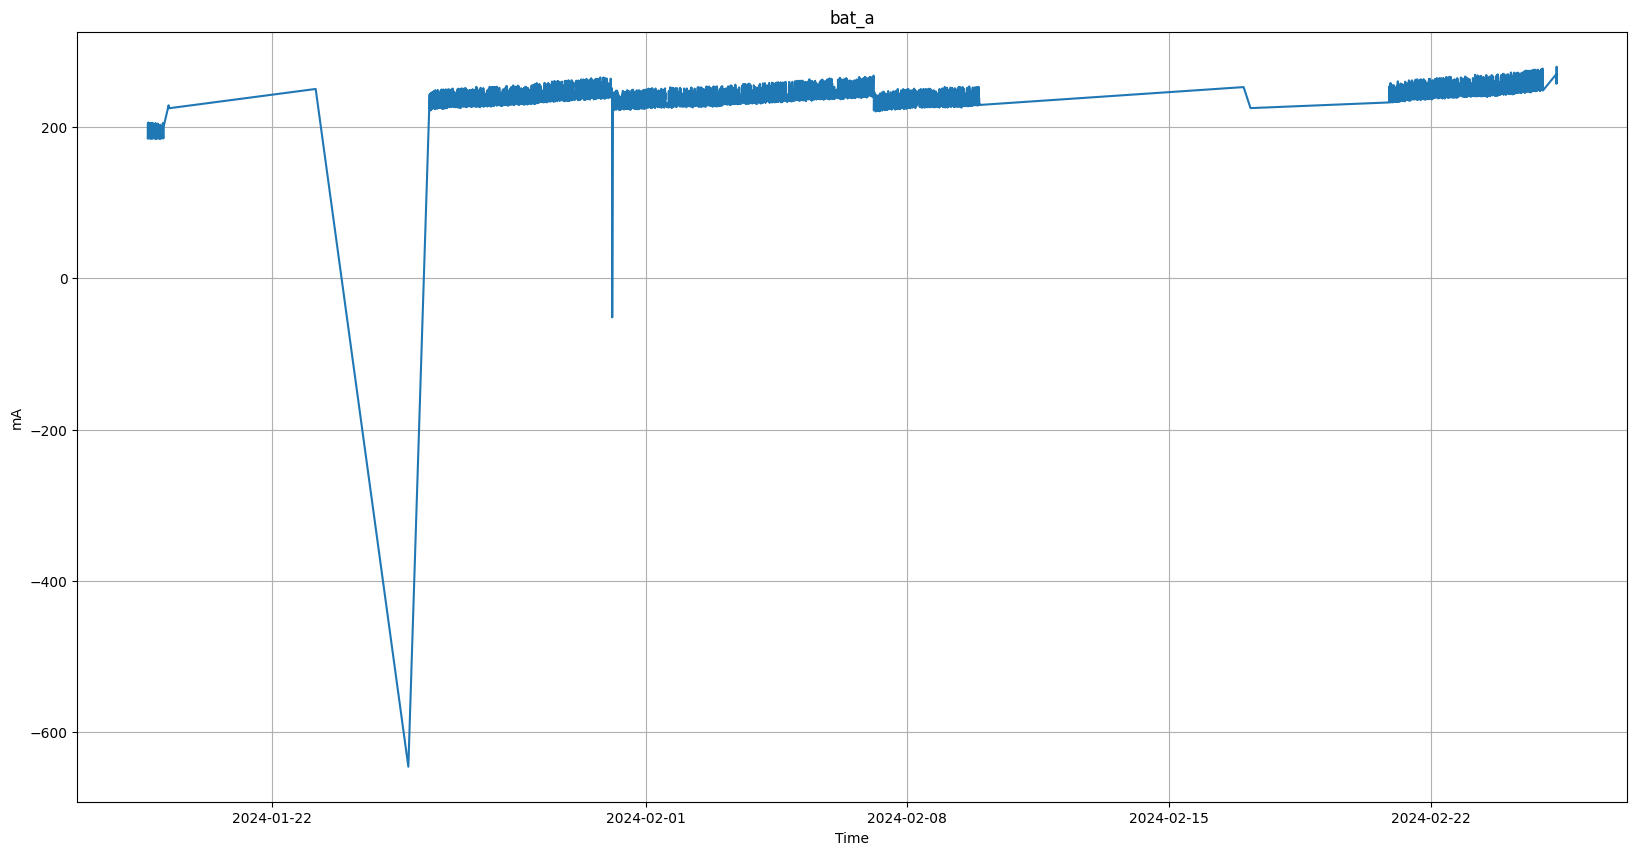

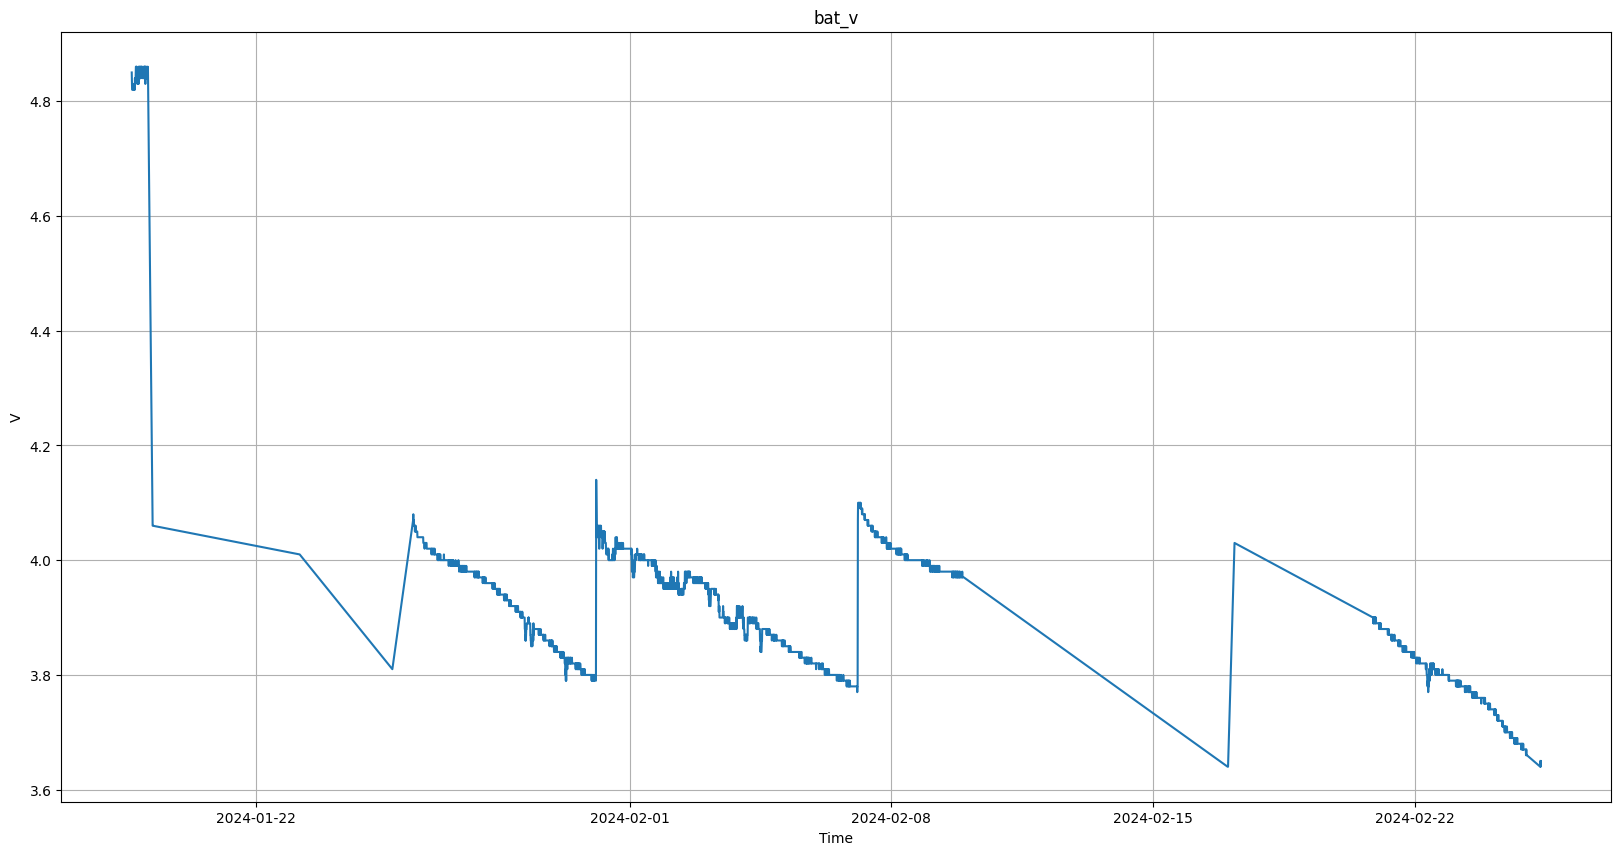

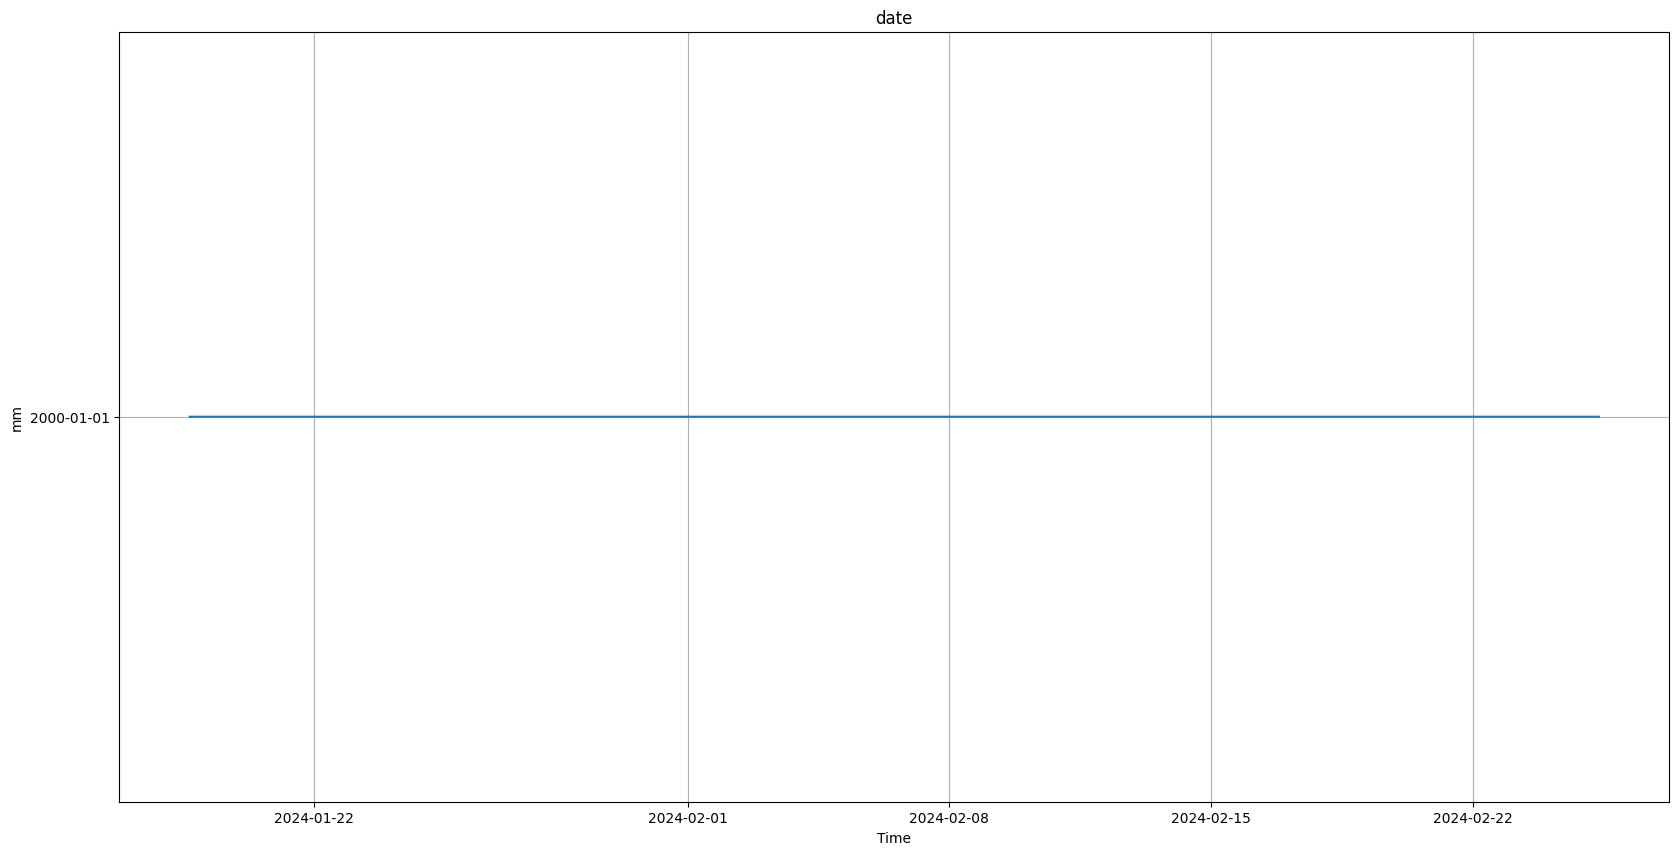

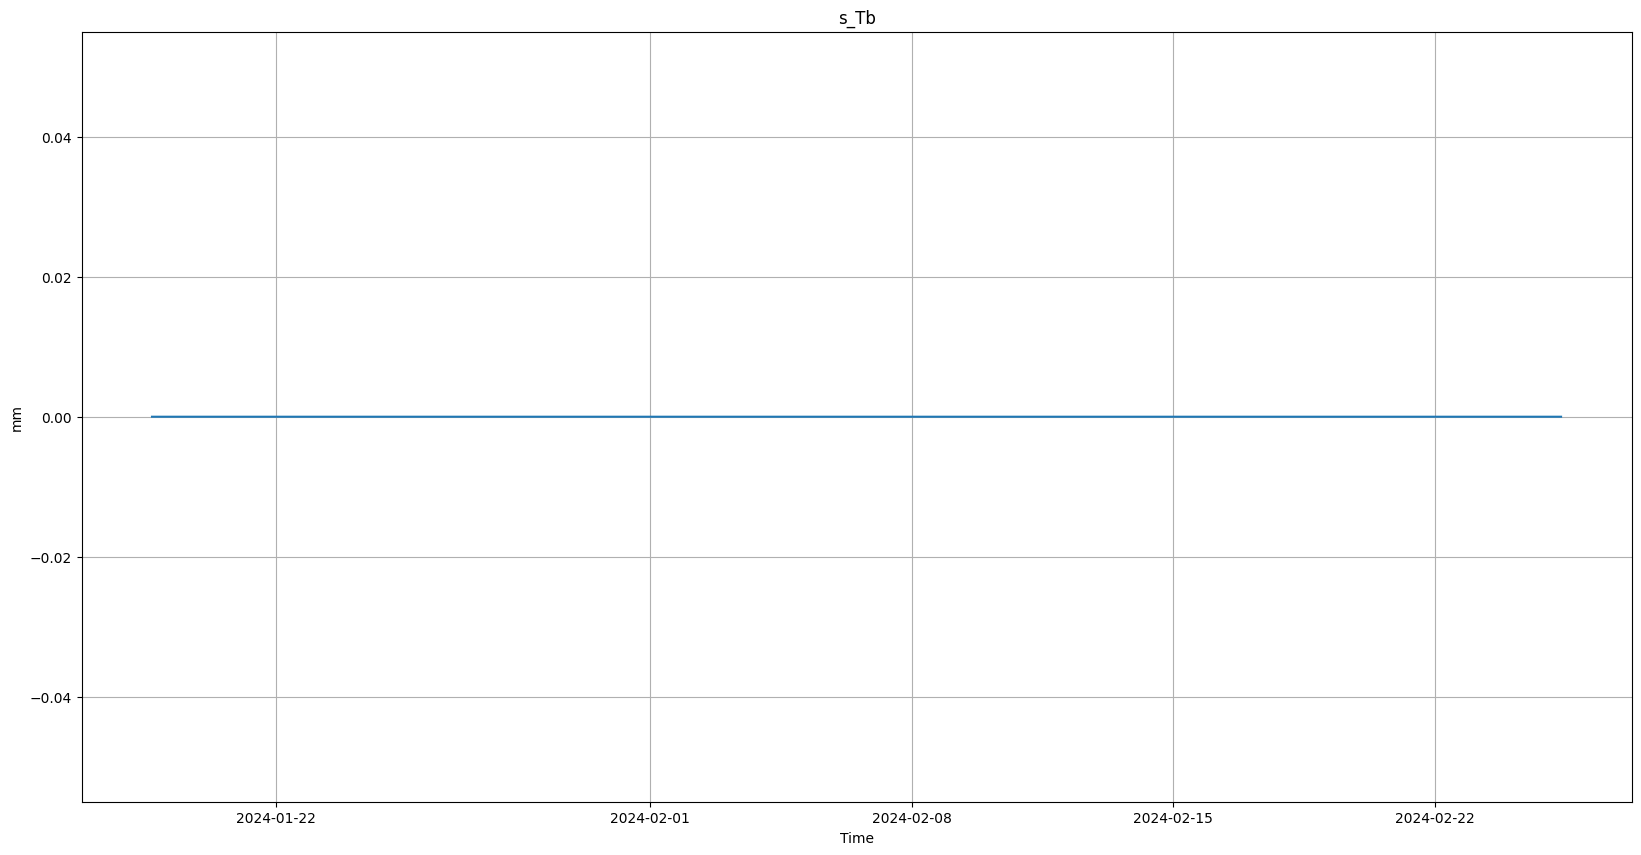

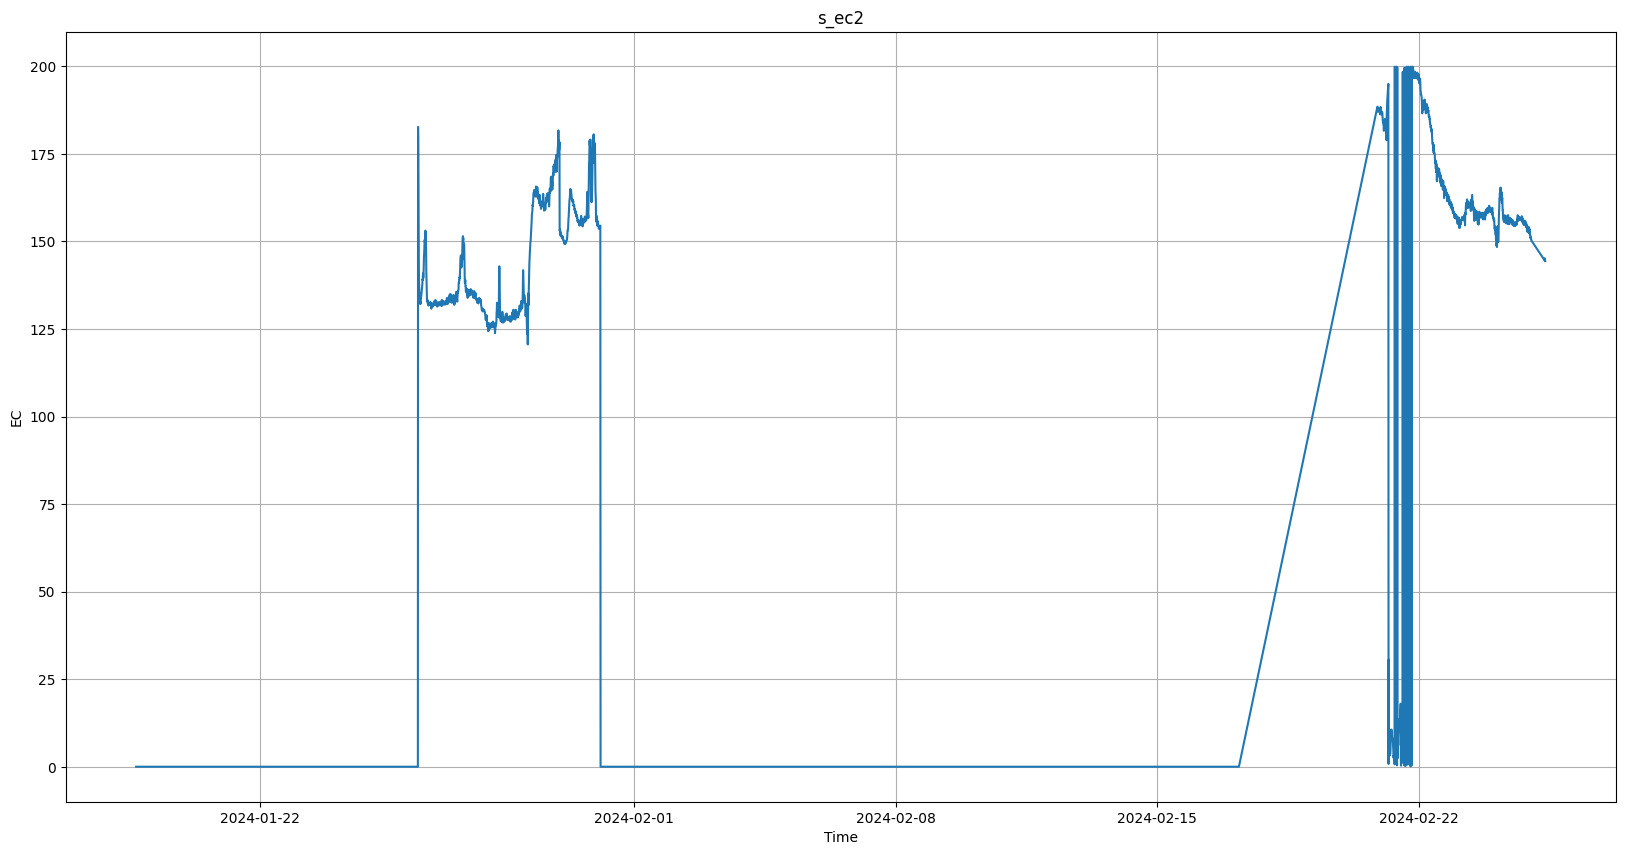

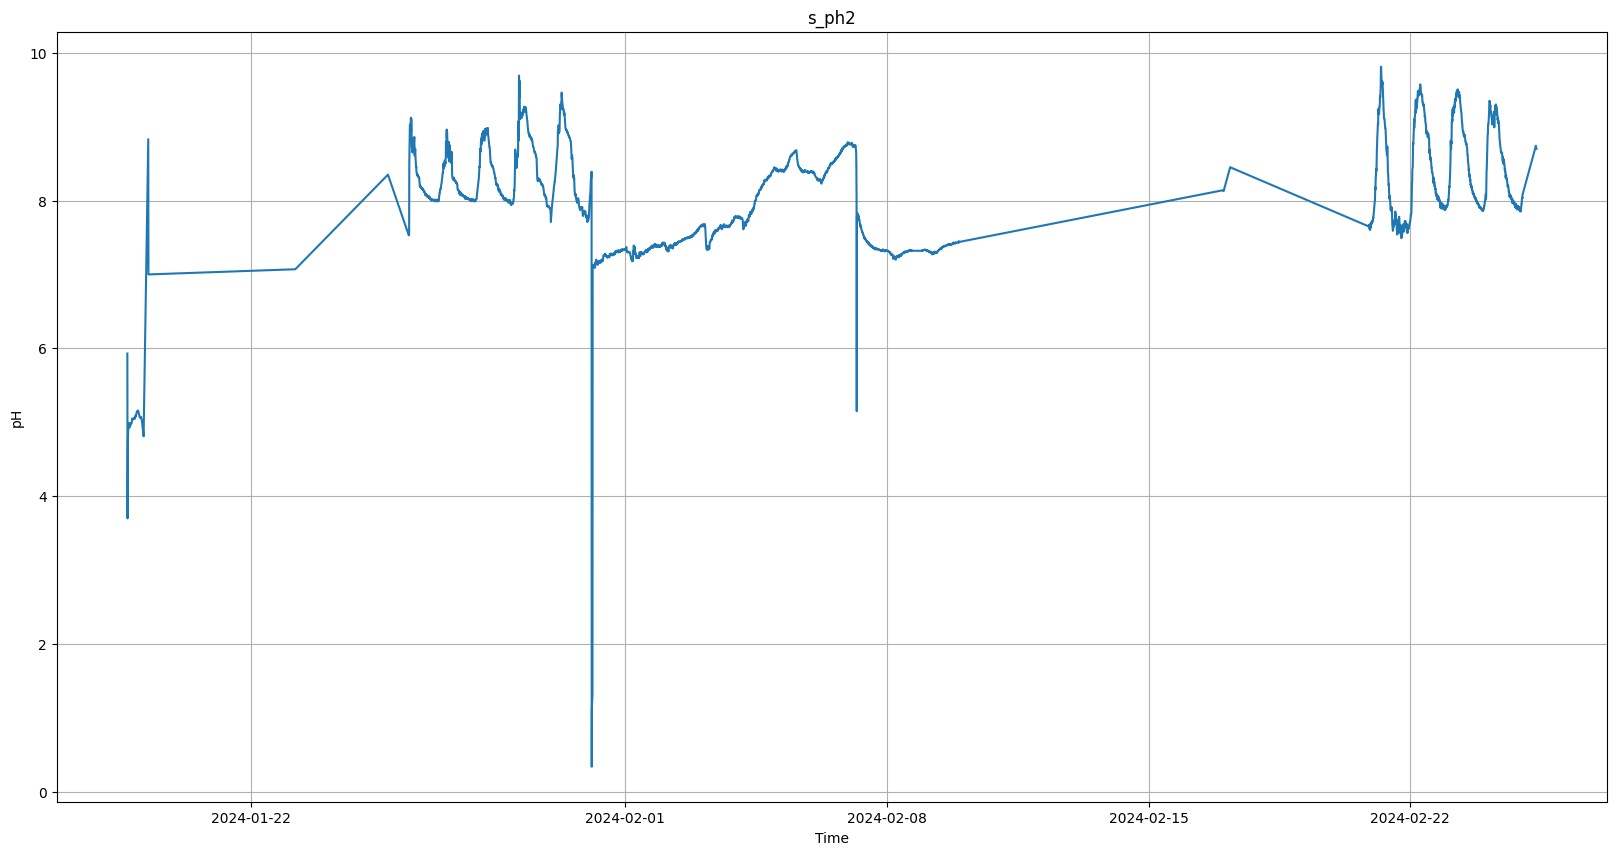

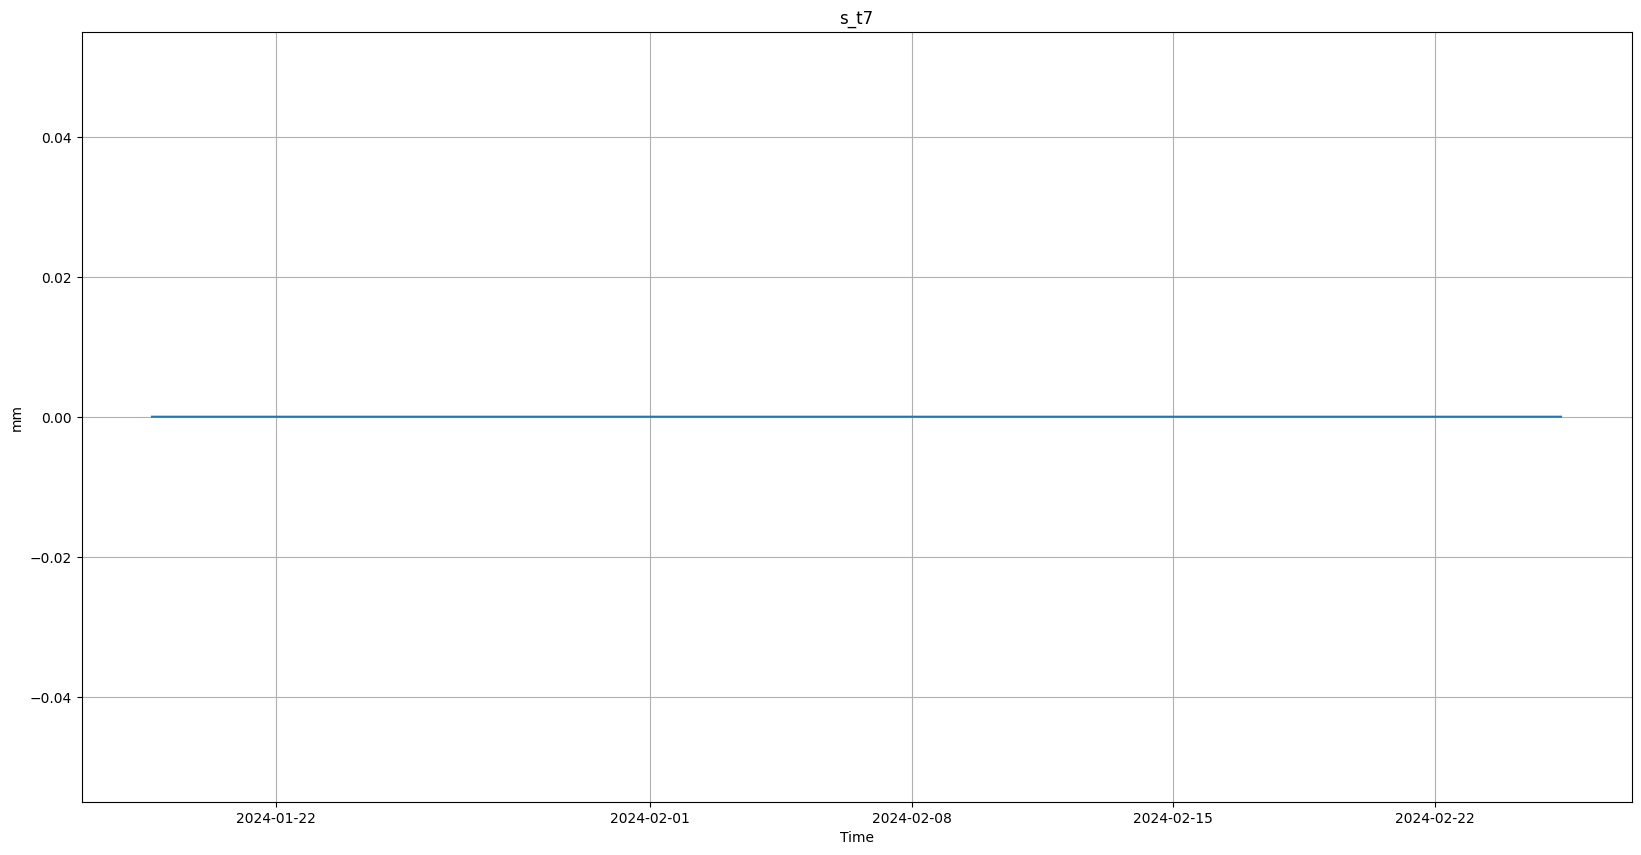

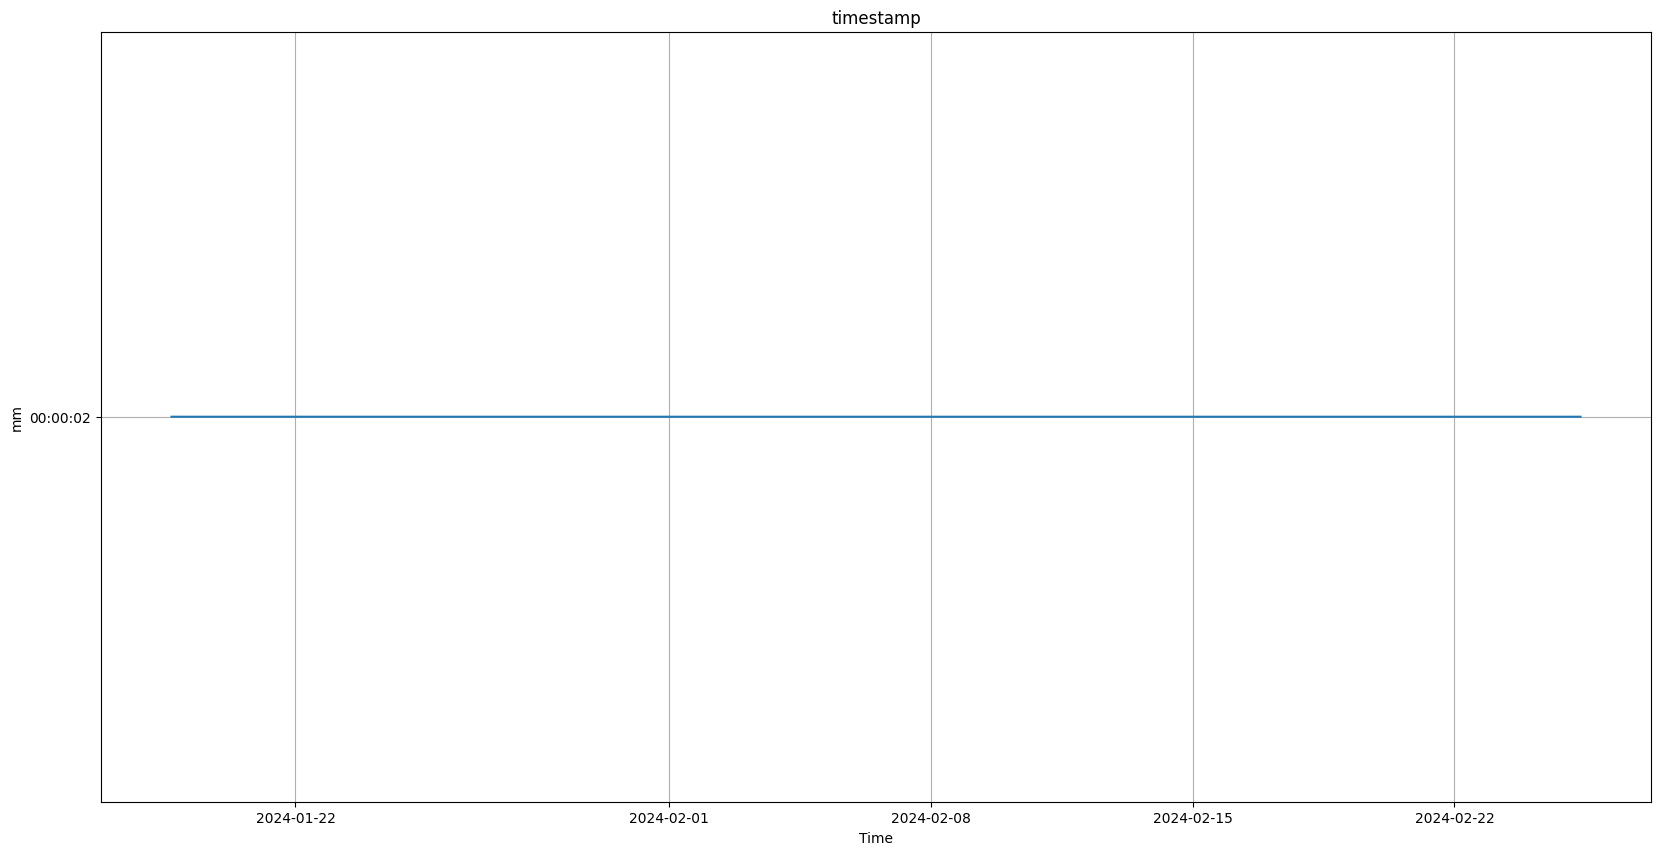

In [2]:
# 迴圈查詢結果中的每個表格
for table in result:
    # 從表格的第一條記錄中獲得欄位名稱（_field）
    field_name = table.records[0].values['_field']
    
    # 提取每個記錄的數據值（_value）
    data = [data.values['_value'] for data in table.records]
    
    # 提取每個記錄的時間戳（_time）
    time = [data.values['_time'] for data in table.records]

    # 設置繪圖的圖形大小
    plt.figure(figsize=(20, 10))
    
    # 設置圖形的標題和 x 軸標籤
    plt.title(field_name)
    plt.xlabel("Time")
    
    # 根據欄位名稱確定 y 軸標籤
    units = {"bat_a": "mA", "bat_v": "V", "s_ec2": "EC", "s_ph2": "pH"}
    ylabel = units.get(field_name, "mm")
    plt.ylabel(ylabel)
    
    # 新增網格線
    plt.grid(True)
    
    # 繪製時間序列數據
    plt.plot(time, data, label=field_name)
